In [1]:
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
import gala.coordinates as gc
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
#import HSS

import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import popsims
import astropy.units as u
import pandas as pd
from astropy.io import ascii

from shapey import Box
#from galpy.actionAngle import actionAngleIsochroneApprox
#from galpy.potential import IsochronePotential
#from galpy.potential import MWPotential
import astropy

#plt.style.use('dark_background')
%matplotlib inline

/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
DATA_FOLDER='/users/caganze/research/J1624/data/'
FIG_FOLDER='/users/caganze/research/J1624/figures/'

In [3]:
#coordinate frame
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame =astro_coord.Galactocentric(galcen_distance=8.2*u.kpc,
                                    galcen_v_sun=v_sun)

#potential
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)


In [4]:
(11.1, 220+24.0, 7.25 )

(11.1, 244.0, 7.25)

In [5]:
def get_phase_space(ra, dec, pmracosdec, pmdec, distance, rv ):
    #ra, dec in degree
    #proper motions in mas/yr
    #distance in pc
    #rv in km/s
    coord=SkyCoord(ra=ra*u.degree, dec=dec*u.degree,  
               pm_ra_cosdec= pmracosdec *u.mas/u.yr, pm_dec=pmdec*u.mas/u.yr, \
               distance=distance*u.pc, 
              radial_velocity= rv*u.km/u.s)
    #phase space position
    pos=gd.PhaseSpacePosition(coord.transform_to(galcen_frame).cartesian)
    

    return coord, pos

In [6]:
J1624_coord={'ra':46.0684208, \
              'dec': -32.2037824,\
              'pmra':np.random.normal(-25.809, 0.159, 1000),
              'pmdec':np.random.normal(-185.783, 0.122, 1000),
              'distance':np.random.normal(16.9465, 0.0356, 1000),
              'rv': np.random.normal(0.23, 0.08, 1000)}
J1624_METAL=(0.29 , 0.07)


In [7]:
#run the orbit a 1000 times incorporating the instrinsic uncertainties in rv,
#distance and proper motion

In [8]:
j1624c, pos=get_phase_space(J1624_coord['ra'], J1624_coord['dec'],\
                       J1624_coord['pmra']*np.cos(J1624_coord['dec']*u.degree), \
                       J1624_coord['pmdec'], J1624_coord['distance'], J1624_coord['rv'])

In [9]:
def compute_actions(pos, plot_all_orbit=False, alpha=1., print_pericenter=False):
    orbit=gp.Hamiltonian(pot).integrate_orbit(pos, dt=3*u.Myr, t1=0*u.Myr, \
                                              t2=2.5*u.Gyr)
    #plot 
    orbit_to_plot=orbit[:,0]
    if plot_all_orbit: orbit_to_plot=orbit
    oplot=orbit_to_plot.cylindrical.plot( components=['rho', 'z', 'v_z'],  \
                                      units=[u.pc, u.pc, u.km/u.s] ,alpha=alpha, c='#0074D9')
    #documentation: http://gala.adrian.pw/en/latest/dynamics/actionangle.html
    toy_potential = gd.fit_isochrone(orbit[:,0])
    print (toy_potential)
    print (np.shape(orbit.z))
    result = [gd.find_actions(orbit[:,idx], N_max=10, toy_potential=toy_potential) \
              for idx in tqdm(np.arange(np.shape(orbit)[-1]))]
    if  print_pericenter:
        apos=[orbit[:,idx].apocenter() for idx in tqdm(np.arange(np.shape(orbit)[-1]))]
        peris=[orbit[:,idx].pericenter() for idx in tqdm(np.arange(np.shape(orbit)[-1]))]
        print ('apocenter --- {} +/- {}'.format(np.nanmedian(u.Quantity(apos)),\
                                                np.nanstd(u.Quantity(apos))))
        print ('pericenter --- {} +/- {}'.format(np.nanmedian(u.Quantity(peris)),\
                                                 np.nanstd(u.Quantity(peris))))
    return pd.DataFrame.from_records(result), oplot


def compute_orbit_and_actions_galpy(pos, plot_all_orbit=False, alpha=1.):
    orbit=gp.Hamiltonian(pot).integrate_orbit(pos, dt=5*u.Myr, t1=0*u.Myr, \
                                              t2=2.5*u.Gyr)
    #plot 
    orbit_to_plot=orbit[:,0]
    if plot_all_orbit: orbit_to_plot=orbit
    oplot=orbit_to_plot.cylindrical.plot( components=['rho', 'z', 'v_z'],  \
                                      units=[u.pc, u.pc, u.km/u.s] ,alpha=alpha, c='#0074D9')
    ts=orbit.t
    galpyo=orbit.to_galpy_orbit()
    #ip= IsochronePotential(b=1.,normalize=1.)
    aAI= actionAngleIsochroneApprox(pot=pot.to_galpy_potential(), b=1.)
    #jfa=aAI.actionsFreqsAngles(galpyo.R(),galpyo.vR(),galpyo.vT(),galpyo.z(),\
    #                   galpyo.vz(),galpyo.phi())
    print (np.shape(galpyo.R()))
    jfa=  aAI.actionsFreqsAngles(galpyo.R().T,galpyo.vR().T,galpyo.vT().T,galpyo.z().T,\
                       galpyo.vz().T,galpyo.phi().T)
    return ts, jfa, oplot

In [10]:
#from galpy.actionAngle import actionAngleIsochroneApprox
#from galpy.potential import LogarithmicHaloPotential
#lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
#aAIA= actionAngleIsochroneApprox(pot=lp,b=0.8)

In [11]:
import gala
gala.__version__

'1.4.2.dev100+g111dba18'

In [12]:
#pot.to_galpy_potential()

IsochronePotential
(834, 1000)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.60it/s]
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


apocenter --- 9.070174646626633 kpc +/- 0.002367891612156877 kpc
pericenter --- 7.763932744873548 kpc +/- 0.0011348240399755073 kpc


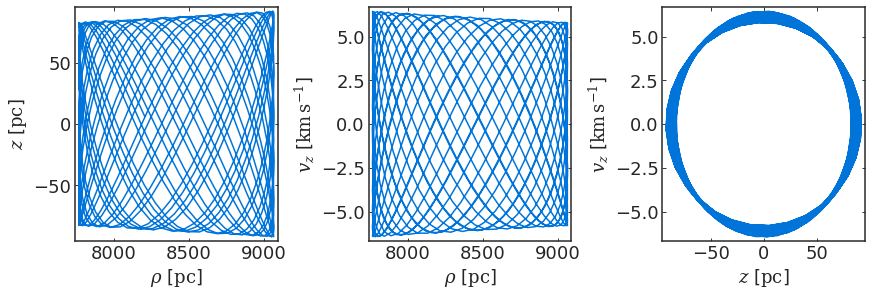

In [13]:
ares=compute_actions(pos, plot_all_orbit=False, alpha=1., print_pericenter=True)

In [14]:
(9.07-8.2)*1000, (9.07-7.7)*1000

(870.000000000001, 1370.0)

In [15]:
ares[0]['actions'][0][0].unit.to(u.kpc**2/u.Gyr)

1000.0

In [16]:
js=np.vstack(ares[0]['actions'].apply(lambda x: np.array(x)).values)
angles=np.vstack(ares[0]['angles'].apply(lambda x: np.array(x)).values)

In [17]:
np.nanmean(js[:,0])*1000, np.nanstd(js[:,0])*1000

(8.16405176262556, 0.027906777097428163)

In [18]:
np.nanmean(js[:,1])*1000, np.nanstd(js[:,1])*1000

(-1975.7741217378934, 0.2902393101402479)

In [19]:
np.nanmean(js[:,-1])*1000, np.nanstd(js[:,-1])*1000

(0.2861427075822087, 0.005958255837528383)

In [20]:
js

array([[ 8.10581128e-03, -1.97541069e+00,  2.73830245e-04],
       [ 8.15496954e-03, -1.97569730e+00,  2.87044529e-04],
       [ 8.20954524e-03, -1.97567984e+00,  2.93711664e-04],
       ...,
       [ 8.17458702e-03, -1.97580709e+00,  2.88050235e-04],
       [ 8.16434170e-03, -1.97586139e+00,  2.89663545e-04],
       [ 8.18386858e-03, -1.97579921e+00,  2.87620218e-04]])

In [21]:
ares[-1].savefig(FIG_FOLDER+'/galatic_orbit.pdf')

In [22]:

bensby=ascii.read(DATA_FOLDER+'/bensby_30pc_gaia1.txt', \
                        names ='ra              de    \
                                [Fe/H]       age1     l_age1     u_age1       \
                                ra_gaia              de_gaia        plx       eplx    \
                                pmra      epmra       pmde      epmde      \
                                rv        erv'.split()).to_pandas()

luck=ascii.read(DATA_FOLDER+'/luck_30pc_gaia1.txt', \
               names='ra              de     [Fe/H]       age1     l_age1    \
               u_age1         ra_gaia         de_gaia        plx       eplx      \
               pmra      epmra       pmde      epmde         rv   \
               erv '.split()).to_pandas()

casgr=ascii.read(DATA_FOLDER+'/casagrande_30pc_gaia1.txt', \
                 names='ra              de     [Fe/H]      ageMP     age16P     \
                 age84P              ra_gaia              de_gaia        \
                 plx       eplx       pmra      epmra       pmde      \
                 epmde         rv        erv'.split()).to_pandas()
spocs=ascii.read(DATA_FOLDER+'/spocs_30pc_gaia1.txt', \
                 names=' ra              de     [Fe/H]       age1     l_age1     u_age1          \
                 ra_gaia              de_gaia        plx       eplx       pmra   \
                 epmra       pmde      epmde         rv        erv '.split()).to_pandas()
                 


In [23]:
luck['pmracosdec']= luck.pmra*np.cos(luck.de*u.degree)
bensby['pmracosdec']= bensby.pmra*np.cos(bensby.de*u.degree)
spocs['pmracosdec']= spocs.pmra*np.cos(spocs.de*u.degree)
casgr['pmracosdec']= casgr.pmra*np.cos(casgr.de*u.degree)

In [24]:
comb=pd.concat([bensby, luck, spocs, casgr.rename(columns={'ageMP':'age1'})])

In [25]:
bcoord, bpos=get_phase_space(comb.ra_gaia.values, comb.de_gaia.values,\
                             comb.pmracosdec.values, \
                comb.pmde.values, 1000/comb.plx.values, comb.rv.values )

IsochronePotential
(834, 1434)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1434/1434 [08:42<00:00,  2.74it/s]


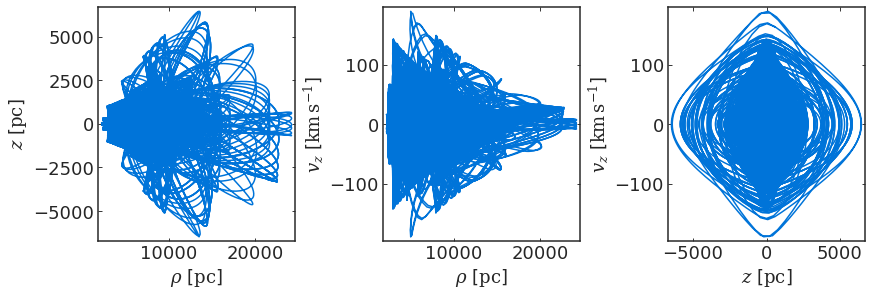

In [26]:
bensby_res=compute_actions(bpos, plot_all_orbit=True, alpha=1.)

In [27]:
bjs=np.vstack(bensby_res[0]['actions'].apply(lambda x: np.array(x)).values)
bas=np.vstack(bensby_res[0]['angles'].apply(lambda x: np.array(x)).values)
bfreqs=np.vstack(bensby_res[0]['freqs'].apply(lambda x: np.array(x)).values)

[(-0.01, 0.1), (-1.0, 10.0)]

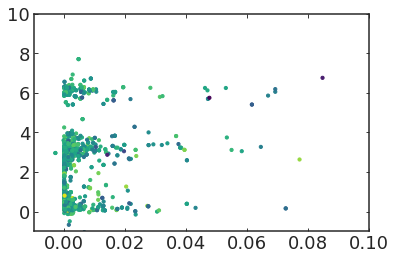

In [28]:
fig, ax=plt.subplots()
ax.scatter(bjs[:,-1], bas[:,-1], c=comb['[Fe/H]'], s=10, cmap='viridis')
ax.set(xlim=[-0.01, 0.1], ylim=[-1, 10])

In [29]:
bjs[:,2].min()

-4.467452108567127

In [30]:
comb['Jr']=bjs[:,0]*1000
comb['Jphi']=bjs[:,1]*1000
comb['Jz']=bjs[:,2]*1000
comb['vtot']=((bcoord.transform_to(galcen_frame).v_x**2+
                bcoord.transform_to(galcen_frame).v_y**2+
                bcoord.transform_to(galcen_frame).v_z**2)**0.5).value
comb['v_x']=bcoord.transform_to(galcen_frame).v_x.value
comb['v_y']=bcoord.transform_to(galcen_frame).v_y.value
comb['v_z']=bcoord.transform_to(galcen_frame).v_z.value

In [31]:
comb.head(5)

,ra,de,[Fe/H],age1,l_age1,u_age1,ra_gaia,de_gaia,plx,eplx,...,pmracosdec,age16P,age84P,Jr,Jphi,Jz,vtot,v_x,v_y,v_z
0,4.224578,-52.651123,-0.54,10.2,5.5,12.5,4.226865,-52.650335,34.0152,0.5274,...,-227.666833,NaN,NaN,109.495426,-2376.220051,0.656212,284.989261,25.286307,283.685866,10.090138
1,8.761744,-63.695180,-0.41,13.1,4.4,13.0,8.770657,-63.697480,35.0336,0.0269,...,577.435826,NaN,NaN,131.143293,-1277.478585,16.113353,160.332110,-27.589843,152.470304,41.206703
2,10.106959,-59.454602,-0.24,6.7,5.8,7.7,10.114684,-59.452627,39.5912,0.0410,...,-859.094338,NaN,NaN,651.577523,-2811.199055,2.136211,344.779305,76.863455,335.534232,-19.533509
3,10.136648,-23.804922,-0.59,12.8,7.9,13.6,10.139887,-23.806466,35.0508,0.0641,...,160.742509,NaN,NaN,37.595478,-1589.582866,23.376594,196.499059,17.185346,189.544483,48.881824
4,11.111044,-26.515682,-0.26,13.1,7.5,13.4,11.112602,-26.515018,29.3187,0.0322,...,58.557432,NaN,NaN,38.292533,-2186.550124,21.932726,265.542116,-8.931004,260.748181,-49.429125


In [32]:
#comb_r=comb.sample(n=int(1e5), replace=True)
comb_r=comb
mask= np.logical_and(comb_r.Jz>-6.5, comb_r['[Fe/H]'].between(-2, 2))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


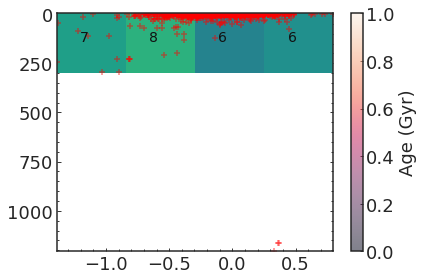

In [33]:
fig, ax=plt.subplots()

popsims.tools.plot_annotated_heatmap(ax, comb_r[['[Fe/H]', 'Jz', 'age1']][mask], 5,
                                     ['[Fe/H]', 'Jz', 'age1'], cmap='viridis', 
                           annotate='third_value', vmin=0, vmax=13, \
                                     textsize=14)
c=ax.scatter(comb['[Fe/H]'],  comb.Jz, marker='+', c='r', alpha=0.5)


cbar=plt.colorbar(c)
cbar.ax.set(ylabel='Age (Gyr)')
ax.minorticks_on()
plt.tight_layout()


In [34]:
j1624c_total_v=(j1624c.transform_to(galcen_frame).v_x**2+
            j1624c.transform_to(galcen_frame).v_y**2+
                j1624c.transform_to(galcen_frame).v_z**2)**0.5



In [35]:

 np.nanmedian(j1624c.transform_to(galcen_frame).v_z ).value


6.328852792221996

In [36]:

 np.nanstd(j1624c.transform_to(galcen_frame).v_z ).value


0.0663353289246317

In [37]:
np.nanmedian((j1624c.transform_to(galcen_frame).v_x**2+
            j1624c.transform_to(galcen_frame).v_y**2)**0.5).value

236.62923188467244

In [38]:
np.nanstd((j1624c.transform_to(galcen_frame).v_x**2+
            j1624c.transform_to(galcen_frame).v_y**2)**0.5).value

0.035335336872961184

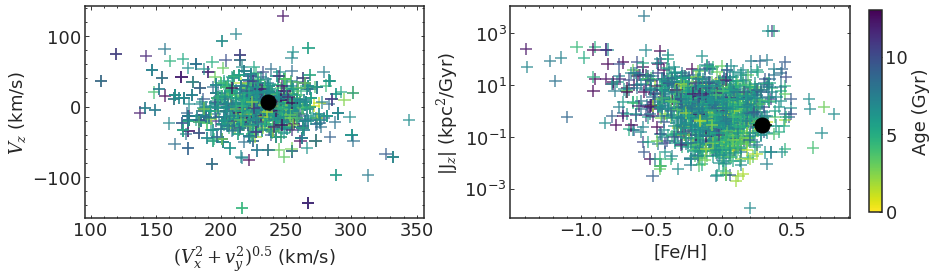

In [39]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))

ax[0].scatter((comb.v_x**2+comb.v_y**2)**0.5, comb.v_z, s=150,  c=comb.age1, \
              marker='+', alpha=.8, cmap='viridis_r', vmin=0, vmax=13)
ax[1].scatter(comb['[Fe/H]'],  abs(comb.Jz), s=150,  c=comb.age1, \
              marker='+', alpha=.8, cmap='viridis_r', vmin=0, vmax=13)


ax[0].errorbar(236, 6.33, xerr=0.036, yerr=0.067, fmt='o', ms=15, c='k')
ax[1].errorbar(J1624_METAL[0], np.nanmedian(js[:,-1]*1000), xerr=J1624_METAL[-1],\
           yerr=np.nanstd(js[:,-1]*1000), marker='o', ms=15, c='k')

ax[0].set(xlabel=r'$(V_x^2+v_y^2)^{0.5}$ (km/s) ', ylabel=r'$V_z$ (km/s)')
ax[1].set(  xlabel='[Fe/H]', \
       ylabel=r'|J$_z$| (kpc$^2$/Gyr) ', yscale='log')

norm= mpl.colors.Normalize(vmin=0,vmax=13)
mp=mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r')
cax = fig.add_axes([1.01, 0.25, .015, 0.7])
cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
cbar.ax.set_ylabel(r'Age (Gyr)', fontsize=18)

plt.tight_layout()
for a in ax:
    a.minorticks_on()
plt.savefig(FIG_FOLDER+'/orbit_age_metallicity.jpeg', rasterized=True, bbox_inches='tight')

In [40]:
#select kinematic cu
kinematic_cut=comb_r.vtot <np.nanmedian(j1624c_total_v).value
metal_cut=np.logical_and(comb_r['[Fe/H]'] <0.5,\
                         comb_r['[Fe/H]'] >0.0)   
angle_cut=  abs(comb_r.Jz)< 1

In [41]:
#read in galah sample
#galah_sam

In [42]:
#bna

NameError: name 'STD_AGE' is not defined

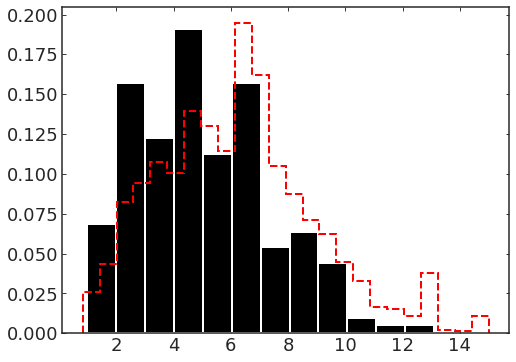

In [43]:
fig, ax=plt.subplots( figsize=(8, 6))
_=ax.hist(comb.age1, histtype='step', bins='auto', lw=2, density=True, \
          linestyle='--', color='r')
#_=sns.kdeplot(comb_r.age1, bw=0.5, lw=2, ax=ax, \
#              linestyle='-', label='sample',  color='y', alpha=0.5)

#_=sns.kdeplot(comb_r.age1[kinematic_cut], bw=0.5, lw=2, ax=ax, \
#              linestyle='dashed', label='Kinematic cut',  color='b', alpha=0.5)

#_=sns.kdeplot(comb_r.age1[metal_cut], bw=0.5, lw=2, ax=ax, \
#              alpha=0.5, color='b', linestyle='dotted', \
#          label='[Fe/H] cut')

#_=sns.kdeplot(comb_r.age1[angle_cut], bw=0.5, lw=2, ax=ax, \
#               alpha=0.5, color='b', linestyle=(0, (3, 1, 1, 1, 1, 1)),
#         label=r'$J_z$ cut')

_=ax.hist(comb_r.age1[np.logical_and.reduce([metal_cut, angle_cut, kinematic_cut])], \
              bins='auto', lw=2, density=True, \
          linestyle='-', color='k')

#ax.axvline( MEDIAN_AGE, c='k')
ax.axvspan(STD_AGE[0], STD_AGE[-1], alpha=0.2, color='blue')
ax.set(xlabel='Age (Gyr)', ylabel='Probability')
plt.legend()
ax.minorticks_on()
plt.savefig(FIG_FOLDER+'/age_constraints.pdf')

In [44]:
print (r'Age {}  -{} +{}'.format(MEDIAN_AGE, MEDIAN_AGE-STD_AGE[0],  \
                                 STD_AGE[1]-MEDIAN_AGE))

NameError: name 'MEDIAN_AGE' is not defined

In [45]:
from astropy.table import Table
merged_file='/volumes/LaCie/galah_merged.fits'
galah= Table.read(merged_file).to_pandas()

In [46]:
galah

,Jphi (kpc2/Myr),Jr (kpc2/Myr),Jz (kpc2/Myr),angle_phi_gala (rad),angle_r_gala (rad),angle_z_gala (rad),freq_phi_gala (rad/Myr),freq_r_gala (rad/Myr),freq_z_gala (rad/Myr),vx_gala (km/s),...,z_Rzphi_95,vR_Rzphi_5,vR_Rzphi_50,vR_Rzphi_95,vT_Rzphi_5,vT_Rzphi_50,vT_Rzphi_95,vz_Rzphi_5,vz_Rzphi_50,vz_Rzphi_95
0,-1.494111,0.060960,0.049897,3.259695,2.392993,6.590825,-0.033371,0.047174,0.052067,-41.244304,...,0.094428,43.143725,43.342442,43.571038,182.387524,182.650797,182.876667,68.492676,68.724868,68.986430
1,-0.704725,0.177451,0.211767,2.021741,4.530091,9.453829,-0.040745,0.063557,0.052476,-73.188621,...,1.258878,46.377706,51.127976,56.193533,137.272901,144.661010,151.855054,90.184118,96.635904,102.998838
2,-1.776966,0.052146,0.026673,2.907811,5.998602,2.099808,-0.029160,0.040116,0.048992,49.587765,...,0.731060,-52.711805,-51.705093,-50.662551,252.751423,252.949600,253.154164,-31.424224,-30.124689,-28.847475
3,-1.710870,0.008602,0.007160,3.110476,3.481401,2.712181,-0.032537,0.044883,0.069315,6.022708,...,0.233921,-6.161504,-5.971453,-5.778935,218.049733,218.435599,218.812503,-25.331573,-25.057874,-24.783078
4,-1.941669,0.046939,0.002503,2.892681,5.278460,1.360067,-0.027575,0.037722,0.063881,55.368170,...,0.272969,-57.897944,-57.274528,-56.706847,246.706582,246.881526,247.073294,1.948257,2.781981,3.561603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701982,-1.776691,0.014941,0.017158,3.460810,2.902418,1.991412,-0.030547,0.042099,0.055496,-65.413738,...,0.544007,10.856274,12.068575,13.454618,206.845499,207.045398,207.254027,-13.126356,-11.545944,-10.095183
701983,-2.238327,0.047462,0.015105,3.255065,7.121838,-0.988739,-0.023110,0.031314,0.039290,-26.558227,...,0.285495,-1.121013,-0.937323,-0.764614,269.227234,269.482601,269.734415,32.367481,32.868661,33.429458
701984,-2.006899,0.017203,0.004184,3.109013,5.238641,2.293165,-0.027147,0.037018,0.058874,4.364937,...,0.317437,-29.412981,-28.934833,-28.529845,243.472549,243.758179,244.038215,-12.030739,-11.552004,-11.118604
701985,-1.762421,0.017678,0.018292,3.471109,2.577089,0.728929,-0.030688,0.042360,0.055249,-65.245053,...,0.608157,19.701500,21.005091,22.284357,205.928217,206.616318,207.345211,17.794294,18.056999,18.281217


In [69]:
def load_schneider_samples():
    
    """
    Read bensby et al, luck et al, cassagrande et al., spocs

    """

    bensby=ascii.read(DATA_FOLDER+'/bensby_30pc_gaia1.txt', \
                            names ='ra              de    \
                                    [Fe/H]       age1     l_age1     u_age1       \
                                    ra_gaia              de_gaia        plx       eplx    \
                                    pmra      epmra       pmde      epmde      \
                                    rv        erv'.split()).to_pandas()

    luck=ascii.read(DATA_FOLDER+'/luck_30pc_gaia1.txt', \
                   names='ra              de     [Fe/H]       age1     l_age1    \
                   u_age1         ra_gaia         de_gaia        plx       eplx      \
                   pmra      epmra       pmde      epmde         rv   \
                   erv '.split()).to_pandas()

    casgr=ascii.read(DATA_FOLDER+'/casagrande_30pc_gaia1.txt', \
                     names='ra              de     [Fe/H]      ageMP     age16P     \
                     age84P              ra_gaia              de_gaia        \
                     plx       eplx       pmra      epmra       pmde      \
                     epmde         rv        erv'.split()).to_pandas()
    spocs=ascii.read(DATA_FOLDER+'/spocs_30pc_gaia1.txt', \
                     names=' ra              de     [Fe/H]       age1     l_age1     u_age1          \
                     ra_gaia              de_gaia        plx       eplx       pmra   \
                     epmra       pmde      epmde         rv        erv '.split()).to_pandas()
    
    luck['pmracosdec']= luck.pmra*np.cos(luck.de*u.degree)
    bensby['pmracosdec']= bensby.pmra*np.cos(bensby.de*u.degree)
    spocs['pmracosdec']= spocs.pmra*np.cos(spocs.de*u.degree)
    casgr['pmracosdec']= casgr.pmra*np.cos(casgr.de*u.degree)
    
    comb=pd.concat([bensby, luck, spocs, casgr.rename(columns={'ageMP':'age1'})])
    
    data= comb
    
    data_coord, data_pos=get_phase_space(data.ra_gaia.values, data.de_gaia.values,\
                             data.pmracosdec.values, \
                data.pmde.values, 1000/data.plx.values, data.rv.values)
    
    data['vtot']=((data_coord.transform_to(galcen_frame).v_x**2+
              data_coord.transform_to(galcen_frame).v_y**2+
              data_coord.transform_to(galcen_frame).v_z**2)**0.5).value
    
   	#if use jz
    total_cut=[]
    data['v_x']=data_coord.transform_to(galcen_frame).v_x.value
    data['v_y']=data_coord.transform_to(galcen_frame).v_y.value
    data['v_z']=data_coord.transform_to(galcen_frame).v_z.value
    data['distance']=1000/data.plx.values
    
    data_res=compute_actions(data_pos, plot_all_orbit=False)
    data_actions=np.vstack(data_res[0]['actions'].apply(lambda x: np.array(x)).values)
    
    data['Jr']=data_actions[:,0]#*1000 #units (kpc$^2$/Myr)
    data['Jphi']=data_actions[:,1]#*1000 
    data['Jz']=data_actions[:,2]#*1000

    return data.rename(columns={'de':'dec', 'pmde':'pmdec'})[['ra', 'dec', 'pmracosdec', 'pmdec', 'distance', 'v_x', \
                  'v_y', 'v_z', 'Jr', 'Jphi', 'Jz']]

def get_galah_sample():
    from astropy.table import Table
    merged_file='/volumes/LaCie/galah_merged.fits'
    galah= Table.read(merged_file).to_pandas()
    galah['vtot']= (galah['vx_gala (km/s)']**2+galah['vy_gala (km/s)']**2+galah['vz_gala (km/s)']**2)**0.5
    galah['pmracosdec']= galah.pmra_edr3*np.cos(pmdec)
    return galah.rename(columns={'vx_gala (km/s)': 'v_x', \
                      'vy_gala (km/s)': 'v_y',  \
                      'vz_gala (km/s)': 'v_z',
                     'fe_h': '[Fe/H]', 
                    'Jr (kpc2/Myr)': 'Jr',
                    'Jphi (kpc2/Myr)': 'Jphi',
                    'Jz (kpc2/Myr)': 'Jz',
                    'age_bstep': 'age1',
                    'ra_dr3': 'ra',
                    'dec_dr3': 'dec',
                     'pmdec_edr3': 'pmdec',
                    })[['ra', 'dec', 'pmracosdec', 'pmdec', 'distance', 'v_x', \
                  'v_y', 'v_z', 'Jr', 'Jphi', 'Jz']]


IsochronePotential
(834, 1434)



  4%|███▉                                                                                                  | 55/1434 [00:19<08:02,  2.86it/s]


  8%|███████▊                                                                                             | 111/1434 [00:39<07:41,  2.86it/s]


 12%|███████████▊                                                                                         | 167/1434 [00:58<07:34,  2.79it/s]


 16%|███████████████▋                                                                                     | 223/1434 [01:18<06:48,  2.96it/s]


 19%|███████████████████▋                                                                                 | 279/1434 [01:38<06:18,  3.05it/s]


 23%|███████████████████████▌                                                                             | 335/1434 [01:57<06:37,  2.76it/s]


 27%|███████████████████████████▌                                                                         | 391/1434 [02:19<06:02,  2.88it/s]


 31%|███████████████████████████████▍                                                                     | 447/1434 [02:37<05:34,  2.95it/s]


 35%|███████████████████████████████████▍                                                                 | 503/1434 [02:57<05:14,  2.96it/s]


 39%|███████████████████████████████████████▎                                                             | 559/1434 [03:17<05:05,  2.87it/s]


 43%|███████████████████████████████████████████▎                                                         | 615/1434 [03:36<04:51,  2.81it/s]


 47%|███████████████████████████████████████████████▎                                                     | 671/1434 [03:55<04:31,  2.81it/s]


 51%|███████████████████████████████████████████████████▏                                                 | 727/1434 [04:16<04:28,  2.63it/s]


 55%|███████████████████████████████████████████████████████▏                                             | 783/1434 [04:36<03:31,  3.08it/s]


 59%|███████████████████████████████████████████████████████████                                          | 839/1434 [04:57<03:40,  2.70it/s]


 62%|███████████████████████████████████████████████████████████████                                      | 895/1434 [05:16<03:05,  2.91it/s]


 66%|██████████████████████████████████████████████████████████████████▉                                  | 951/1434 [05:39<02:55,  2.75it/s]


 70%|██████████████████████████████████████████████████████████████████████▏                             | 1007/1434 [05:59<02:24,  2.95it/s]


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 1063/1434 [06:18<02:07,  2.92it/s]


 78%|██████████████████████████████████████████████████████████████████████████████                      | 1119/1434 [06:39<02:01,  2.59it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 1175/1434 [06:59<01:39,  2.62it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████▊              | 1231/1434 [07:19<01:05,  3.10it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▋          | 1287/1434 [07:38<00:47,  3.08it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▋      | 1343/1434 [07:57<00:32,  2.77it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1399/1434 [08:17<00:13,  2.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1434/1434 [08:28<00:00,  2.82it/s]


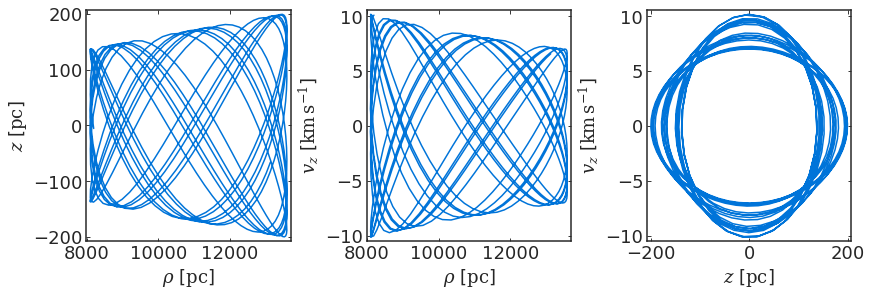

In [68]:
df0=load_schneider_samples()

In [70]:
df2=get_galah_sample()

KeyError: "['ra', 'dec', 'pmracosdec', 'distance', 'Jr', 'Jphi'] not in index"

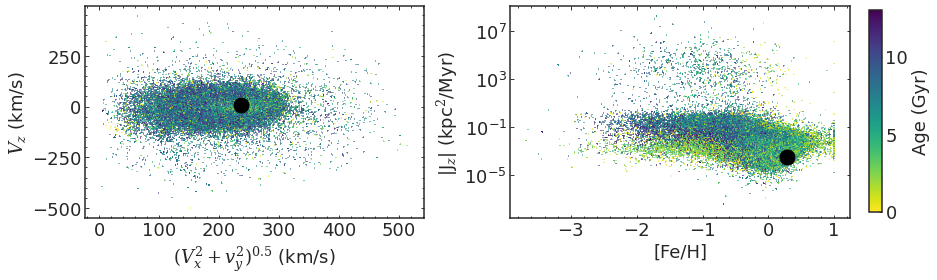

In [48]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))

ax[0].scatter((galah['vx_gala (km/s)']**2+galah['vy_gala (km/s)']**2)**0.5, \
              galah['vz_gala (km/s)'],  c=galah.age_bstep, \
              marker='+', alpha=.8, s=0.1, cmap='viridis_r', vmin=0, vmax=13)
ax[1].scatter(galah['fe_h'],  np.abs(galah['Jz (kpc2/Myr)']),   c=galah.age_bstep, \
              marker='+', alpha=.8, s=0.1,cmap='viridis_r', vmin=0, vmax=13)


ax[0].errorbar(236, 6.33, xerr=0.036, yerr=0.067, fmt='o', ms=15, c='k')
ax[1].errorbar(J1624_METAL[0], np.nanmedian(js[:,-1]), xerr=J1624_METAL[-1],\
           yerr=np.nanstd(js[:,-1]), marker='o', ms=15, c='k')

ax[0].set(xlabel=r'$(V_x^2+v_y^2)^{0.5}$ (km/s) ', ylabel=r'$V_z$ (km/s)')
ax[1].set(  xlabel='[Fe/H]', \
       ylabel=r'|J$_z$| (kpc$^2$/Myr) ', yscale='log')

norm= mpl.colors.Normalize(vmin=0,vmax=13)
mp=mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r')
cax = fig.add_axes([1.01, 0.25, .015, 0.7])
cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
cbar.ax.set_ylabel(r'Age (Gyr)', fontsize=18)

plt.tight_layout()
for a in ax:
    a.minorticks_on()
plt.savefig(FIG_FOLDER+'/orbit_age_metallicity_galah.jpeg', rasterized=True, bbox_inches='tight')

In [ ]:
#galah cuts
galah_vcut=(galah['vx_gala (km/s)']**2+galah['vy_gala (km/s)']**2+ galah['vz_gala (km/s)']**2 )**0.5 <np.nanmedian(j1624c_total_v).value
galah_metal_cut=np.logical_and(galah['fe_h'] >0.29 -0.07,\
                         galah['fe_h'] <0.29 + 0.07)   
galah_angle_cut=np.logical_and(np.abs(galah['Jz (kpc2/Myr)'])>  np.nanmedian(js[:,-1])-  np.nanstd(js[:,-1]),\
                           np.abs(galah['Jz (kpc2/Myr)'])<  np.nanmedian(js[:,-1])+  np.nanstd(js[:,-1]))
                           

In [ ]:
mask=np.logical_and.reduce([galah_vcut, galah_metal_cut, galah_angle_cut])

In [ ]:
np.nanmedian(galah.age_bstep[mask]), np.nanstd(galah.age_bstep[mask])

In [ ]:
comb